# Compare offline turbulence to observations
### function of wind shear and temperature gradient

In [2]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xr
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import scipy.io as sio
import copy

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
import kgraph
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import matplotlib.gridspec as gridspec

import turbpy

## Directories

In [3]:
# Project directory
dir_proj = '/Users/karllapo/proj/SnowHydro_OfflineTurb'
dir_print = os.path.join(dir_proj, 'graphics')

# Data
dir_data = os.path.join(dir_proj, 'data')
dir_snq = os.path.join(dir_data, 'SNQ')
dir_scp = os.path.join(dir_data, 'SCP')

# Model output
dir_model_ouptut = os.path.join(dir_data, 'results')

## Configure graphing

In [4]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Define a default color palette (this should be fairly color blind friendly)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(sns.color_palette(flatui))

# Define a line style list
ls_list = ['-', '--', ':', '-']

# This is only relevant if you have a retina screen
%config InlineBackend.figure_format = 'retina'

import string
alphabet = list(string.ascii_lowercase)

### Surface observations

In [5]:
# -------------------------------------------------------------------------------------------------------
# SNQ
os.chdir(dir_snq)
snq = xr.open_dataset('SnoqualmieObs.SupportData.wy2013_wy2015.nc')

ribulk = turbpy.bulkRichardson(snq.T6 + 273.15 + 0.06,
                               snq.Tsrf + 273.15,
                               snq.WIND,
                               6. - snq.Snowdepth)

snq_ind = np.nonzero((ribulk > 0.).values)

# -------------------------------------------------------------------------------------------------------
# SCP
os.chdir(dir_scp)
radObs = xr.open_dataset('SCP.rad_obs.netcdf')
scp = xr.open_dataset('SCP.Mtower_pottemps.nc')
fluxObs = xr.open_dataset('SCP.flux_obs.netcdf')

# Turbulence
scp['obs_qh_2m'] = fluxObs.w_tc__2m_M
scp['obs_qh_10m'] = fluxObs.w_tc__10m_M

# Indices of stable periods
ri = turbpy.bulkRichardson(scp['theta_10m'] + 273.15, scp['Tsfc'] + 273.15, scp['UBar_10m'], 10.)
scp['RiBulk_10m'] = (('time'), ri)
scp_ind_10m = np.nonzero((scp.RiBulk_10m > 0.).values)

ri = turbpy.bulkRichardson(scp['theta_2m'] + 273.15, scp['Tsfc'] + 273.15, scp['UBar_2m'], 2.)
scp['RiBulk_2m'] = (('time'), ri)
scp_ind_2m = np.nonzero((scp.RiBulk_2m > 0.).values)

## Offline Turbulence results

#### SCP
- Run in the script TF.SUMMATurbConversion_SCP.py script on j-lundquist-3
- Results saved to OfflineTurb.SCP.sensible_1m.ALL.nc. The "ALL" refers to doing offline simulations on all stable conditions, instead of just a 5% sample, as in previous iterations.
- The criteria for stable conditions comes from the 15m observations

#### SNQ
- Simulation run in TF.OfflineTurb.SNQ
- the resulting netcdf was copied from the SNQ data directory to the project level directory. Re-running the script won't change the results in this script unless explicitly moved again.
- Simulations only run for periods of wind > 2m/s

In [6]:
# Set up the parameters for running turbpy
stab_titles = ('Standard',
               'Louis (b = 4.7)',
               'Louis (b = 12)',
               'Louis (Ri capped, MJ98)',
               'MO (Holtslag/de Bruin)',
               'MO (Holtslag/de Bruin - capped)',
               'MO (Beljaars/Holtslag)',
               'MO (Webb - NoahMP)',
               'MO (Cheng/Brutsaert)',
              )

axis_titles = {'Standard': 'Standard',
               'Louis (b = 4.7)': ' Louis',
               'Louis (b = 12)': 'Louis (modified)',
               'Louis (Ri capped, MJ98)': 'Louis (capped)',
               'MO (Holtslag/de Bruin)': 'HD88',
               'MO (Holtslag/de Bruin - capped)': 'HD88 (capped)',
               'MO (Beljaars/Holtslag)': 'BH91',
               'MO (Webb - NoahMP)': 'Webb',
               'MO (Cheng/Brutsaert)': 'CB05',}

# Titles for output and xarray datasets
out_titles = {'Standard': 'standard',
               'Louis (b = 4.7)': 'louis',
               'Louis (b = 12)': 'louis_mod',
               'Louis (Ri capped, MJ98)': 'louis_cap',
               'MO (Holtslag/de Bruin)': 'HD88',
               'MO (Holtslag/de Bruin - capped)': 'HD88_cap',
               'MO (Beljaars/Holtslag)': 'BJ91',
               'MO (Webb - NoahMP)': 'webb_noah',
               'MO (Cheng/Brutsaert)': 'CB05',
             }

stab_methods = {'Standard': 'standard',
                'Louis (b = 4.7)': 'louis',
                'Louis (b = 12)': 'louis',
                'Louis (Ri capped, MJ98)': 'louis',
                'MO (Holtslag/de Bruin)': 'monin_obukhov',
                'MO (Holtslag/de Bruin - capped)': 'monin_obukhov',
                'MO (Beljaars/Holtslag)': 'monin_obukhov',
                'MO (Webb - NoahMP)': 'monin_obukhov',
                'MO (Cheng/Brutsaert)': 'monin_obukhov',
               }

gradient_funcs = {'MO (Holtslag/de Bruin)': 'holtslag_debruin',
                  'MO (Holtslag/de Bruin - capped)': 'holtslag_debruin',
                  'MO (Beljaars/Holtslag)': 'beljaar_holtslag',
                  'MO (Beljaars/Holtslag - capped)': 'beljaar_holtslag',
                  'MO (Cheng/Brutsaert)': 'cheng_brutsaert',
                  'MO (Webb - NoahMP)': 'webb_noahmp',
                 }

In [7]:
os.chdir(dir_model_ouptut)
z0assumption = 'constant_z0'

# -------------------------------------------------------------------------------------------------------
# SNQ Offline Turbulence results
snq_qh = xr.open_dataset('TF.SNQ.sensible_revisions.' + z0assumption + '.nc')

# -------------------------------------------------------------------------------------------------------
# SCP Offline Turbulence results
scp_2m = xr.open_dataset('TF.SCP.sensible_2m_revision.' + z0assumption + '.nc')
scp_10m = xr.open_dataset('TF.SCP.sensible_10m_revision.' + z0assumption + '.nc')

# Temperature Gradient

In [8]:
# Group a variable according to a proxy variable (e.g., group air temperature according to the stability)
def proxyGroupby(ds, binVar, binVals, digitVar, method='mean'):
    proxyGroups = np.digitize(ds[binVar].values, binVals, right=False)
    groupVar = np.zeros(np.size(binVals))
    
    if method == 'mean':
        for bnum, bV in enumerate(binVals):
            if np.count_nonzero(ds[digitVar][proxyGroups == bnum + 1]) < 5:
                groupVar[bnum] = np.nan
            else:
                groupVar[bnum] = np.nanmean(ds[digitVar][proxyGroups == bnum + 1])

        return groupVar
    
    elif method == 'count':
        for bnum, bV in enumerate(binVals):
            groupVar[bnum] = np.count_nonzero(ds[digitVar][proxyGroups == bnum + 1])

        return groupVar

[        nan  1.11111111  1.17056856  0.81833061  0.63694268  0.81967213
  0.67842605  0.71856287  1.00446429  0.84835631  0.55803571  1.25348189
  0.5952381   0.97465887  0.25188917  0.32786885  0.44843049  0.63291139
  0.85470085  1.26582278  2.04081633  4.34782609  0.        ]


KeyError: 'Mahrt'

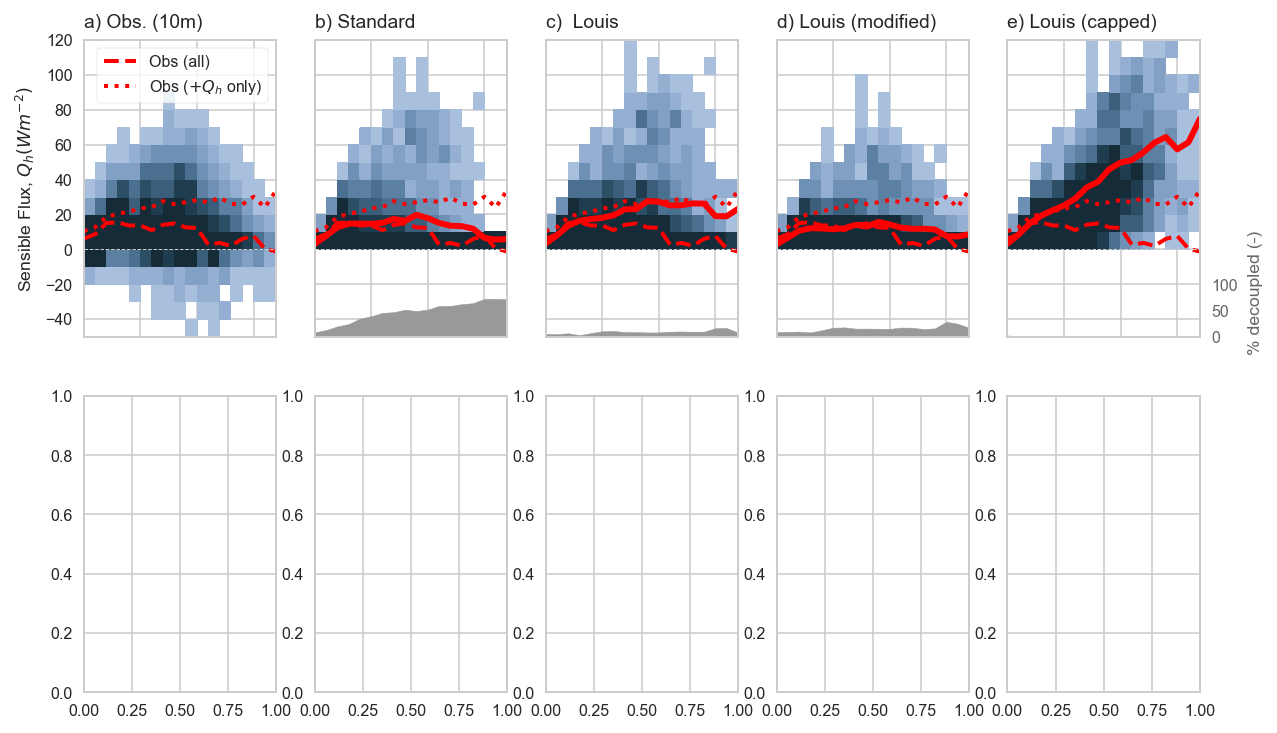

In [12]:
# -------------------------------------------------------------------------------------------------------
# SCP Upper Obs

# Temperature gradient bins
binTempGrad = np.arange(-0.5, 11, 0.5)

# Add temp grad to datasets
scp_10m['tempGrad'] = scp.theta_10m[scp_ind_10m] - scp.Tsfc[scp_ind_10m]

scp_temp = scp.isel(time=scp_ind_10m[0])
scp_temp['tempGrad'] = (scp_temp.theta_10m - scp_temp.Tsfc)

scp_ind_10m_noncg = np.nonzero(((scp.RiBulk_10m > 0.).values) & ((-scp.obs_qh_10m > 0)).values)
scp_temp_nocg = scp.isel_points(time=scp_ind_10m_noncg[0])
scp_temp_nocg['tempGrad'] = (scp_temp_nocg.theta_10m - scp_temp_nocg.Tsfc)

# Bin obs
groupQhObs = proxyGroupby(scp_temp, 'tempGrad', binTempGrad, 'obs_qh_10m')
groupQhObs_nocg = proxyGroupby(scp_temp_nocg, 'tempGrad', binTempGrad, 'obs_qh_10m')

# Limits
ymin = -50
ymax = 120
xmin = 0
xmax = 8.5
dy = 10
dx = .5
small_qh_crit = 0.1

# Format figure
## General colorbar arguments
cmin = 0
cmax = 100
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)
cmap = kgraph.cmap_discretize(cmap, ncol)
fig, axes = plt.subplots(2, 5, figsize=(10, 6))#, sharex=True, sharey=True)
axes = axes.flatten()

## Observed turbulence
ax = axes[0]

# Build my own histogram
X = (scp.theta_10m[scp_ind_10m] - scp.Tsfc[scp_ind_10m]).values.flatten()
Y = -scp.obs_qh_10m[scp_ind_10m].values.flatten()  
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                               np.arange(ymin, ymax + dy, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)
# Plot my 2D histogram
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
ax.plot(binTempGrad, -groupQhObs, '--r', linewidth=2, label='Obs (all)')
ax.plot(binTempGrad, -groupQhObs_nocg, ':r', linewidth=2, label='Obs ($+Q_h$ only)')

ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
ax.set_title('a) Obs. (10m)', loc='left')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.grid()
ax.set_ylabel('Sensible Flux, $Q_h (Wm^{-2})$')
ax.set_xticklabels(())
ax.legend(loc='upper right', frameon=True)

## Count of very small fluxes
ax2 = ax.twinx()
small_qh = xr.Dataset()
small_qh['obs_qh_10m'] = scp.obs_qh_10m[scp_ind_10m].where(np.abs(scp.obs_qh_10m[scp_ind_10m]) <= small_qh_crit, drop=True)
small_qh['tempGrad'] = scp_temp['tempGrad'].reindex_like(small_qh)
group_small_qh = proxyGroupby(small_qh, 'tempGrad', binTempGrad, 'obs_qh_10m', method='count')
group_all_qh = proxyGroupby(scp_temp, 'tempGrad', binTempGrad, 'obs_qh_10m', method='count')

ax2.fill_between(binTempGrad, 0, group_small_qh / group_all_qh * 100, color='0.6')
print(group_small_qh / group_all_qh * 100)

if ax.is_last_col():
    ax2.set_ylabel('% decoupled (-)', color='0.6')
    ax2.tick_params('y', colors='0.6')
else:
    ax2.set_yticklabels(())
ax2.set_ylim(0, (ymax - ymin) / 30 * 100)
ax2.grid(False)

## Simulated turbulence
for ix, stab in enumerate(stab_titles):
    ax = axes[ix + 1]
    method = out_titles[stab]
   
    # Bin the model output
    groupQh = proxyGroupby(scp_10m, 'tempGrad', binTempGrad, method)

    # Build my own histogram
    X = (scp.theta_10m[scp_ind_10m] - scp.Tsfc[scp_ind_10m]).values.flatten()
    Y = scp_10m[method].values.flatten()  
    H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                                   np.arange(ymin, ymax + dy, dy)))
    H = np.ma.masked_array(H, H < cmin + dcol)
    # Plot my 2D histogram
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
    ax.plot(binTempGrad, groupQh, 'r', linewidth=3, label='Model')
    ax.plot(binTempGrad, -groupQhObs, '--r', linewidth=2)
    ax.plot(binTempGrad, -groupQhObs_nocg, ':r', linewidth=2)

    ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
    ax.set_title(alphabet[ix + 1] + ') ' + axis_titles[stab], loc='left')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    if ax.is_last_row():
        ax.set_xlabel(r'$\theta_{air} - \theta_{sfc} (^{\circ} C)$')
    else:
        ax.set_xticklabels(())
    if ax.is_first_col():
        ax.set_ylabel('Sensible Flux, $Q_h (Wm^{-2})$')
    else:
        ax.set_yticklabels(())
    ax.grid()

    ## Count of very small fluxes
    ax2 = ax.twinx()
    small_qh = xr.Dataset()
    small_qh[method] = scp_10m[method].where(scp_10m[method] <= small_qh_crit, drop=True)
    small_qh['tempGrad'] = copy.deepcopy(scp_temp['tempGrad'].reindex_like(small_qh))
    group_small_qh = proxyGroupby(small_qh, 'tempGrad', binTempGrad, method, method='count')
    group_all_qh = proxyGroupby(scp_10m, 'tempGrad', binTempGrad, method, method='count')

    ax2.fill_between(binTempGrad, 0, group_small_qh / group_all_qh * 100, color='0.6')
    
    ax2.set_yticks((0, 50, 100))
    if ax.is_last_col():
        ax2.set_ylabel('% decoupled (-)', color='0.4')
        ax2.tick_params('y', colors='0.4')
        ax2.set_yticklabels((0, 50, 100))
        ax2.yaxis.set_label_coords(1.25, 0.15)

    else:
        ax2.set_yticklabels(())
    ax2.set_ylim(0, (ymax - ymin) / 30 * 100)
    ax2.grid(False)

os.chdir(dir_print)
ax.legend(frameon=True)
fig.savefig('2dHist_TempGrad.SCP_10m.' + context + '.' + z0assumption + '.pdf', dpi=300)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Dataset.isel_points is deprecated: use Dataset.isel()instead.
  del sys.path[0]
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide


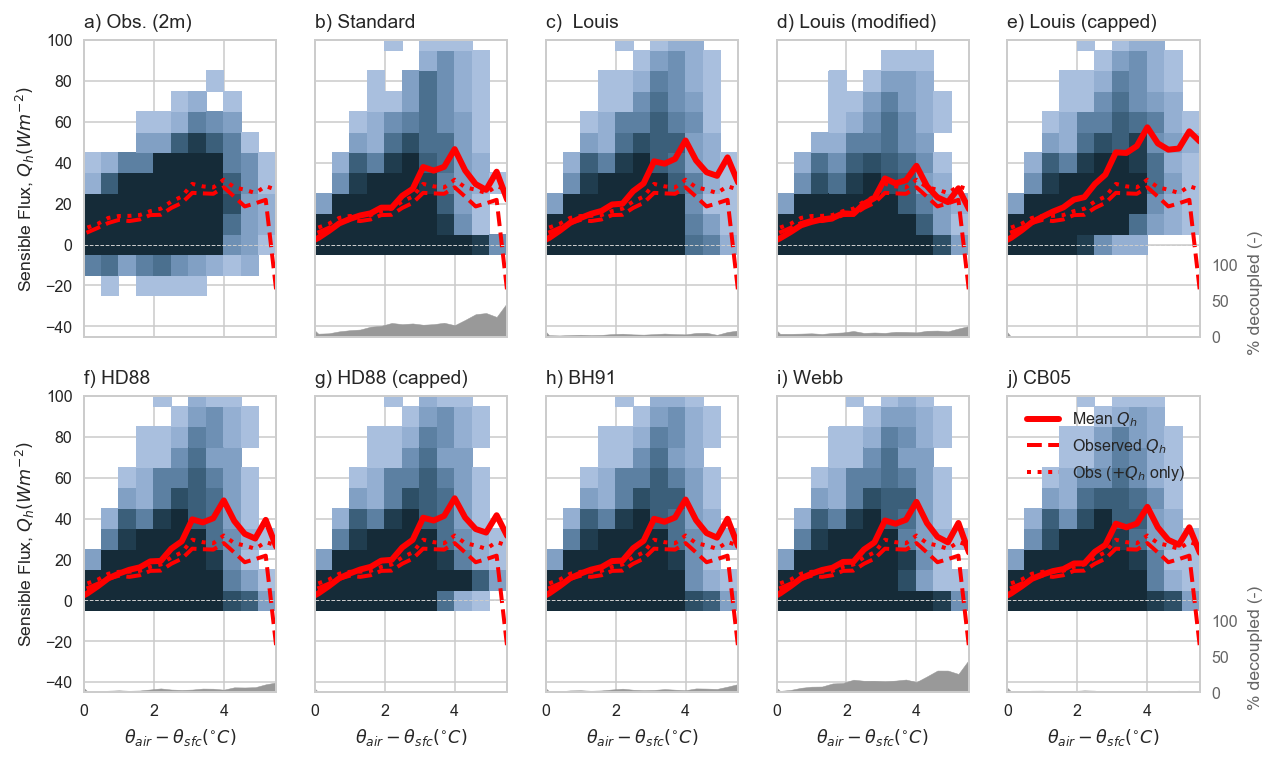

In [9]:
# -------------------------------------------------------------------------------------------------------
# SCP Lower Obs

# Temperature gradient bins
binTempGrad = np.arange(-0.5, 5.8, 0.3)

# Add temp grad to datasets
scp_2m['tempGrad'] = scp.theta_2m[scp_ind_2m] - scp.Tsfc[scp_ind_2m]
scp_temp = scp
scp_temp['tempGrad'] = (scp.theta_2m - scp.Tsfc)

scp_ind_2m_noncg = np.nonzero(((scp.RiBulk_2m > 0.).values) & ((-scp.obs_qh_2m > 0)).values)
scp_temp_nocg = scp.isel_points(time=scp_ind_2m_noncg[0])
scp_temp_nocg['tempGrad'] = (scp_temp_nocg.theta_2m - scp_temp_nocg.Tsfc)

# Bin obs
groupQhObs = proxyGroupby(scp_temp, 'tempGrad', binTempGrad, 'obs_qh_2m')
groupQhObs_nocg = proxyGroupby(scp_temp_nocg, 'tempGrad', binTempGrad, 'obs_qh_2m')

# Limits
ymin = -45
ymax = 100
xmin = 0
xmax = 5.5
dy = 10
dx = .5

# Format figure
## General colorbar arguments
cmin = 0
cmax = 100
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)
cmap = kgraph.cmap_discretize(cmap, ncol)
fig, axes = plt.subplots(2, 5, figsize=(10, 6))#, sharex=True, sharey=True)
axes = axes.flatten()

## Observed turbulence
ax = axes[0]

# Build my own histogram
X = (scp.theta_2m[scp_ind_2m] - scp.Tsfc[scp_ind_2m]).values.flatten()
Y = -scp.obs_qh_2m[scp_ind_2m].values.flatten()  
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                               np.arange(ymin, ymax + dy, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)
# Plot my 2D histogram
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
ax.plot(binTempGrad, -groupQhObs, '--r', linewidth=2)
ax.plot(binTempGrad, -groupQhObs_nocg, ':r', linewidth=2, label='Obs ($+Q_h$ only)')

ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
ax.set_title('a) Obs. (2m)', loc='left')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.grid()
ax.set_ylabel('Sensible Flux, $Q_h (Wm^{-2})$')
ax.set_xticklabels(())

# Simulated turbulence
for ix, stab in enumerate(stab_titles):
    ax = axes[ix + 1]
    method = out_titles[stab]
   
    # Bin the model output
    groupQh = proxyGroupby(scp_2m, 'tempGrad', binTempGrad, method)

    # Build my own histogram
    X = (scp.theta_2m[scp_ind_2m] - scp.Tsfc[scp_ind_2m]).values.flatten()
    Y = scp_2m[method].values.flatten()  
    H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                                   np.arange(ymin, ymax + dy, dy)))
    H = np.ma.masked_array(H, H < cmin + dcol)
    # Plot my 2D histogram
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
    ax.plot(binTempGrad, groupQh, 'r', linewidth=3, label='Mean $Q_h$')
    ax.plot(binTempGrad, -groupQhObs, '--r', linewidth=2, label='Observed $Q_h$')
    ax.plot(binTempGrad, -groupQhObs_nocg, ':r', linewidth=2, label='Obs ($+Q_h$ only)')

    ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
    ax.set_title(alphabet[ix + 1] + ') ' + axis_titles[stab], loc='left')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    if ax.is_last_row():
        ax.set_xlabel(r'$\theta_{air} - \theta_{sfc} (^{\circ} C)$')
    else:
        ax.set_xticklabels(())
    if ax.is_first_col():
        ax.set_ylabel('Sensible Flux, $Q_h (Wm^{-2})$')
    else:
        ax.set_yticklabels(())
    ax.grid()

    ## Count of very small fluxes
    ax2 = ax.twinx()
    small_qh = xr.Dataset()
    small_qh[method] = scp_2m[method].where(scp_2m[method] <= small_qh_crit, drop=True)
    small_qh['tempGrad'] = copy.deepcopy(scp['tempGrad'].reindex_like(small_qh))
    group_small_qh = proxyGroupby(small_qh, 'tempGrad', binTempGrad, method, method='count')
    group_all_qh = proxyGroupby(scp_2m, 'tempGrad', binTempGrad, method, method='count')

    ax2.fill_between(binTempGrad, 0, group_small_qh / group_all_qh * 100, color='0.6')
    
    ax2.set_yticks((0, 50, 100))
    if ax.is_last_col():
        ax2.set_ylabel('% decoupled (-)', color='0.4')
        ax2.tick_params('y', colors='0.4')
        ax2.set_yticklabels((0, 50, 100))
        ax2.yaxis.set_label_coords(1.25, 0.15)

    else:
        ax2.set_yticklabels(())
    ax2.set_ylim(0, (ymax - ymin) / 35 * 100)
    ax2.grid(False)
    
ax.legend()

fig.savefig('2dHist_TempGrad.SCP_2m.' + context + '.' + z0assumption + '.pdf', dpi=300)

/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:973: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


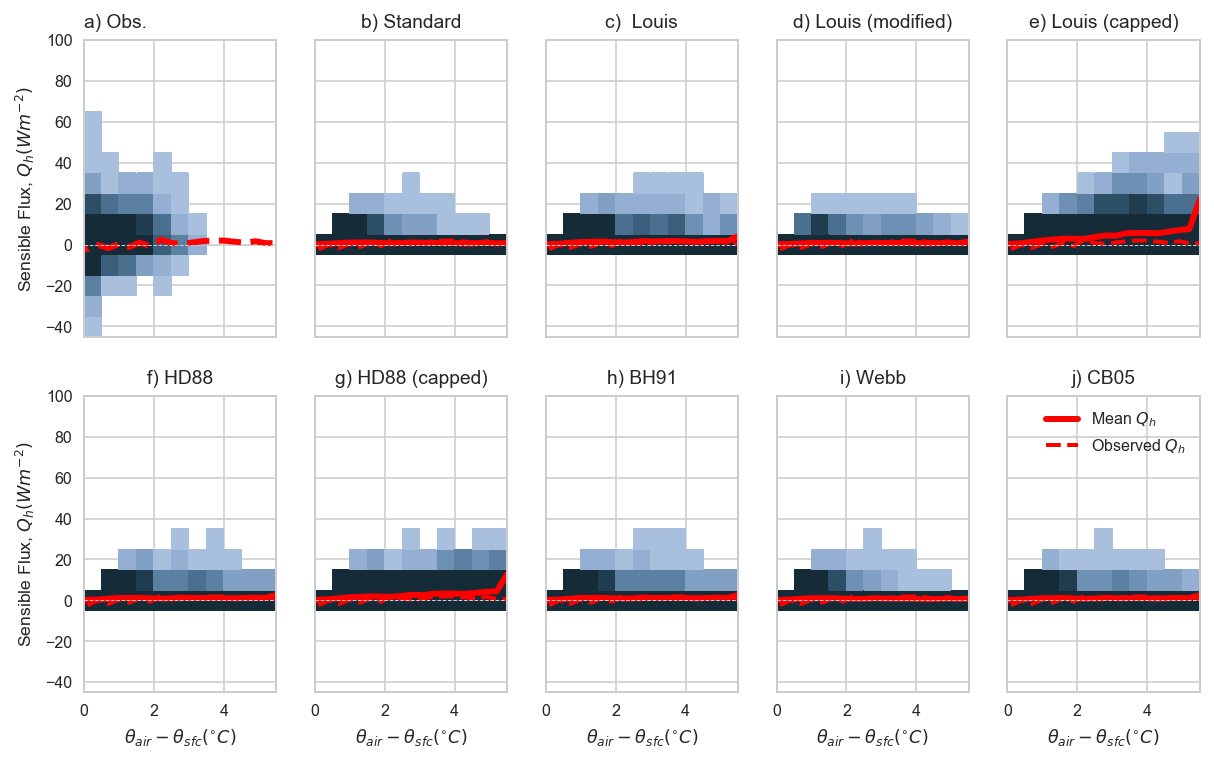

In [10]:
# -------------------------------------------------------------------------------------------------------
# SNQ
os.chdir(dir_print)

# Temporary dataset with only the stable observations
snq_temp = snq.isel(time=snq_ind[0])

# Temperature gradient bins
binTempGrad = np.arange(-0.5, 5.8, 0.3)

# Add temp grad to datasets
snq_qh['tempGrad'] = snq.T6[snq_ind] - snq.Tsrf[snq_ind]
snq_temp = snq
snq_temp['tempGrad'] = (snq.T6 - snq.Tsrf)

# Bin obs
groupQhObs = proxyGroupby(snq_temp, 'tempGrad', binTempGrad, 'SensFlux')

# Limits
ymin = -45
ymax = 100
xmin = 0
xmax = 5.5
dy = 10
dx = .5

# Figure formatting
fig, axes = plt.subplots(2, 5, figsize=(10, 6))#, sharex=True, sharey=True)
axes = axes.flatten()
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)
cmap = kgraph.cmap_discretize(cmap, ncol)

# Observed turbulence
ax = axes[0]

# Build my own histogram
X = snq.WIND[snq_ind].values.flatten()
Y = snq.SensFlux[snq_ind].values.flatten()  
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                               np.arange(ymin, ymax + dy, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)

# Plot my 2D histogram
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
ax.plot(binTempGrad, groupQhObs, '--r', linewidth=3, label='Mean $Q_h$')

ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
ax.set_title('a) Obs.', loc='left')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.grid()
ax.set_ylabel('Sensible Flux, $Q_h (Wm^{-2})$')
ax.set_xticklabels(())

# Simulated turbulence
for ix, stab in enumerate(stab_titles):
    ax = axes[ix + 1]
    method = out_titles[stab]

    # Bin the model output
    groupQh = proxyGroupby(snq_qh, 'tempGrad', binTempGrad, method)
    
    # Build my own histogram
    X = snq.tempGrad[snq_ind].values.flatten()
    Y = snq_qh[method].values.flatten()  
    H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                                   np.arange(ymin, ymax + dy, dy)))
    H = np.ma.masked_array(H, H < cmin + dcol)
    # Plot my 2D histogram
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
    ax.plot(binTempGrad, groupQh, 'r', linewidth=3, label='Mean $Q_h$')
    ax.plot(binTempGrad, groupQhObs, '--r', linewidth=2, label='Observed $Q_h$')

    ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
    ax.set_title(alphabet[ix + 1] + ') ' + axis_titles[stab])
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    
    if ax.is_last_row():
        ax.set_xlabel(r'$\theta_{air} - \theta_{sfc} (^{\circ} C)$')
    else:
        ax.set_xticklabels(())
    if ax.is_first_col():
        ax.set_ylabel('Sensible Flux, $Q_h (Wm^{-2})$')
    else:
        ax.set_yticklabels(())
    ax.grid()

ax.legend()

# The missing subaxis needs to be dealt with.
# ax = axes[-1]
# ax.set_xlabel(r'$\theta_{air} - \theta_{sfc} (^{\circ} C)$')
# ax.set_xticks((0, 2.5, 5, 7.5))
# ax.set_xticklabels(('0.0', '2.5', '5.0', '7.5'))

    
# Space for adding the colorbar
# ax = axes[-1]
# ax.axis('off')

fig.savefig('2dHist_TempGrad.SNQ.' + context + '.' + z0assumption + '.pdf', dpi=300)

lol this is so weird looking. No function of $Q_h$ with the temperature gradient is just so bizarre. I have to assume it is a result of the exceptionally low wind speeds at this site. From experience, the wind is so still, especially at night when snow is present, that it feels so much colder than an area that is exposed. I always assumed that the outoging radiation dominates the energy balance. This result _really_ seems to confirm that intuition.

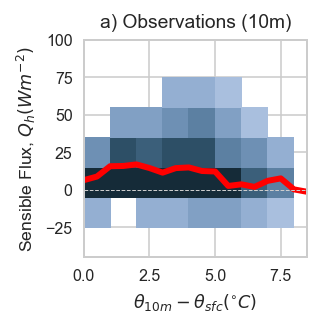

In [11]:
# Temperature gradient bins
binTempGrad = np.arange(-0.5, 11, 0.5)

# Add temp grad to datasets
scp_10m['tempGrad'] = scp.theta_10m[scp_ind_10m] - scp.Tsfc[scp_ind_10m]
scp_temp = scp
scp_temp['tempGrad'] = (scp.theta_10m - scp.Tsfc)

# Bin obs
groupQhObs = proxyGroupby(scp_temp, 'tempGrad', binTempGrad, 'obs_qh_10m')

# Limits
ymin = -45
ymax = 100
xmin = 0
xmax = 8.5
dy = 10
dx = .5

# Format figure
## General colorbar arguments
cmin = 0
cmax = 500
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)
cmap = kgraph.cmap_discretize(cmap, ncol)
fig, ax = plt.subplots(1, 1, figsize=(2, 2))#, sharex=True, sharey=True)

## Observed turbulence

# Build my own histogram
X = (scp.theta_10m[scp_ind_10m] - scp.Tsfc[scp_ind_10m]).values.flatten()
Y = -scp.obs_qh_10m[scp_ind_10m].values.flatten()  
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax, dx + dx),
                                               np.arange(ymin, ymax, dy + dy)))
H = np.ma.masked_array(H, H < cmin + dcol)
# Plot my 2D histogram
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
ax.plot(binTempGrad, -groupQhObs, 'r', linewidth=3)

ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
ax.set_title('a) Observations (10m)')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$\theta_{10m} - \theta_{sfc} (^{\circ} C)$')
ax.grid()
ax.set_ylabel('Sensible Flux, $Q_h (Wm^{-2})$')

fig.savefig('2dHist_TempGrad.obs_scp10m.' + context + '.' + z0assumption + '.pdf', bbox_inches='tight')

# Wind

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Dataset.isel_points is deprecated: use Dataset.isel()instead.
  


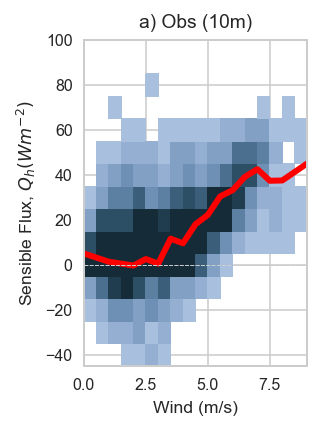

In [12]:
os.chdir(dir_print)
# -------------------------------------------------------------------------------------------------------
# SCP Obs only (Wind)
# Temperature gradient bins
# Add temp grad to datasets
scp_temp = scp.isel_points(time=scp_ind_10m[0])

binWind = np.append(np.arange(0, 2, 1), np.arange(2, 8, 0.5))
binWind = np.append(binWind, np.arange(8, 11, 1))

# Bin obs
groupQhObs = proxyGroupby(scp_temp, 'UBar_10m', binWind, 'obs_qh_10m')

# Limits
ymin = -45
ymax = 100
xmin = 0
xmax = 9
dy = 10
dx = .5

# Format figure
## General colorbar arguments
cmin = 0
cmax = 100
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)
cmap = kgraph.cmap_discretize(cmap, ncol)
fig, ax = plt.subplots(1, 1, figsize=(2, 3), sharex='col', sharey='row')

## Observed turbulence

# Build my own histogram
X = scp.UBar_10m[scp_ind_10m].values.flatten()
Y = -scp.obs_qh_10m[scp_ind_10m].values.flatten()  
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                               np.arange(ymin, ymax + dy, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)

# Plot my 2D histogram
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
ax.plot(binWind, -groupQhObs, 'r', linewidth=3, label='Mean $Q_h$')

ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
ax.set_title('a) Obs (10m)')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Wind (m/s)')
ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
ax.grid()
ax.set_ylabel('Sensible Flux, $Q_h (Wm^{-2})$')
# ax.legend()
fig.savefig('2dHist_Wind.obs_scp10m.' + context + '.' + z0assumption + '.pdf', bbox_inches='tight')

## Simulated fluxes vs wind speed

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Dataset.isel_points is deprecated: use Dataset.isel()instead.
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Dataset.isel_points is deprecated: use Dataset.isel()instead.
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in true_divide


[ 1.07615894  1.47347741  1.28976784  0.78585462  0.32502709  0.9478673
  0.68493151  0.37523452  0.          0.          0.          0.          0.
  0.          0.53763441  0.81967213         nan]


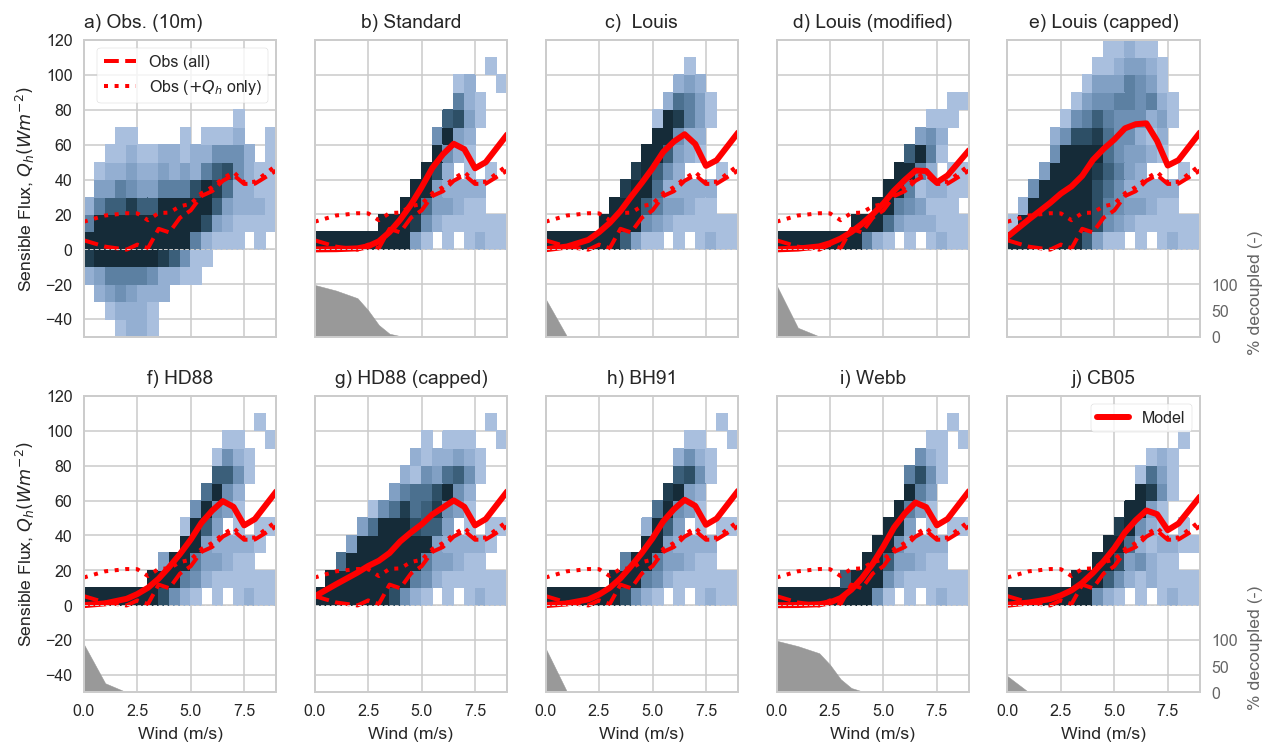

In [13]:
# -------------------------------------------------------------------------------------------------------
# SCP Upper Obs
os.chdir(dir_print)

# Temporary dataset with only the stable observations
scp_temp = scp.isel_points(time=scp_ind_10m[0])
scp_ind_10m_noncg = np.nonzero(((scp.RiBulk_10m > 0.).values) & ((-scp.obs_qh_10m > 0)).values)
scp_temp_nocg = scp.isel_points(time=scp_ind_10m_noncg[0])
scp_10m['UBar_10m'] = scp.UBar_10m[scp_ind_10m]

# Temperature gradient bins
binWind = np.append(np.arange(0, 2, 1), np.arange(2, 8, 0.5))
binWind = np.append(binWind, np.arange(8, 11, 1))

# Bin obs
groupQhObs = proxyGroupby(scp_temp, 'UBar_10m', binWind, 'obs_qh_10m')
groupQhObs_nocg = proxyGroupby(scp_temp_nocg, 'UBar_10m', binWind, 'obs_qh_10m')

# Small flux threshold
small_qh_crit = 0.1

# Figure formatting
fig, axes = plt.subplots(2, 5, figsize=(10, 6))#, sharex=True, sharey=True)
axes = axes.flatten()
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)
cmap = kgraph.cmap_discretize(cmap, ncol)

ymin = -50
ymax = 120
xmin = 0
xmax = 9

## Observed turbulence
ax = axes[0]

# Build my own histogram
X = scp.UBar_10m[scp_ind_10m].values.flatten()
Y = -scp.obs_qh_10m[scp_ind_10m].values.flatten()  
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                               np.arange(ymin, ymax + dy, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)

# Plot my 2D histogram
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
ax.plot(binWind, -groupQhObs, '--r', linewidth=2, label='Obs (all)')
ax.plot(binWind, -groupQhObs_nocg, ':r', linewidth=2, label='Obs ($+Q_h$ only)')

ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
ax.set_title('a) Obs. (10m)', loc='left')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.grid()
ax.set_ylabel('Sensible Flux, $Q_h (Wm^{-2})$')
ax.set_xticklabels(())
ax.legend(frameon=True, loc='upper right')

## Count of very small fluxes (<= 0.5Wm-2)
ax2 = ax.twinx()
small_qh = xr.Dataset()
small_qh['obs_qh_10m'] = scp.obs_qh_10m[scp_ind_10m].where(np.abs(scp.obs_qh_10m[scp_ind_10m]) <= small_qh_crit, drop=True)
small_qh['UBar_10m'] = copy.deepcopy(scp['UBar_10m'].reindex_like(small_qh))
group_small_qh = proxyGroupby(small_qh, 'UBar_10m', binWind, 'obs_qh_10m', method='count')
group_all_qh = proxyGroupby(scp_temp, 'UBar_10m', binWind, 'obs_qh_10m', method='count')

ax2.fill_between(binWind, 0, group_small_qh / group_all_qh * 100, color='0.6')
print(group_small_qh / group_all_qh * 100)

if ax.is_last_col():
    ax2.set_ylabel('% decoupled (-)', color='0.6')
    ax2.tick_params('y', colors='0.6')
else:
    ax2.set_yticklabels(())
ax2.set_ylim(0, (ymax - ymin) / 30 * 100)
ax2.grid(False)

# Simulated turbulence
for ix, stab in enumerate(stab_titles):
    ax = axes[ix + 1]
    method = out_titles[stab]

    ## 2D Histogram
    # Bin the model output
    groupQh = proxyGroupby(scp_10m, 'UBar_10m', binWind, method)
    
    # Build my own histogram
    X = scp.UBar_10m[scp_ind_10m].values.flatten()
    Y = scp_10m[method].values.flatten()  
    H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                                   np.arange(ymin, ymax + dy, dy)))
    H = np.ma.masked_array(H, H < cmin + dcol)
    # Plot my 2D histogram
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
    ax.plot(binWind, groupQh, 'r', linewidth=3, label='Model')
    ax.plot(binWind, -groupQhObs, '--r', linewidth=2)
    ax.plot(binWind, -groupQhObs_nocg, ':r', linewidth=2)

    ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
    ax.set_title(alphabet[ix + 1] + ') ' + axis_titles[stab])
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    
    if ax.is_last_row():
        ax.set_xlabel('Wind (m/s)')
    else:
        ax.set_xticklabels(())
    if ax.is_first_col():
        ax.set_ylabel('Sensible Flux, $Q_h (Wm^{-2})$')
    else:
        ax.set_yticklabels(())
    ax.grid()
    
    ## Count of very small fluxes (<= 0.5Wm-2)
    ax2 = ax.twinx()
    small_qh = xr.Dataset()
    small_qh[method] = scp_10m[method].where(scp_10m[method] <= small_qh_crit, drop=True)
    small_qh['UBar_10m'] = copy.deepcopy(scp['UBar_10m'].reindex_like(small_qh))
    group_small_qh = proxyGroupby(small_qh, 'UBar_10m', binWind, method, method='count')
    group_all_qh = proxyGroupby(scp_10m, 'UBar_10m', binWind, method, method='count')

    ax2.fill_between(binWind, 0, group_small_qh / group_all_qh * 100, color='0.6')
    
    ax2.set_yticks((0, 50, 100))
    if ax.is_last_col():
        ax2.set_ylabel('% decoupled (-)', color='0.4')
        ax2.tick_params('y', colors='0.4')
        ax2.set_yticklabels((0, 50, 100))
        ax2.yaxis.set_label_coords(1.25, 0.15)

    else:
        ax2.set_yticklabels(())
    ax2.set_ylim(0, (ymax - ymin) / 30 * 100)
    ax2.grid(False)

ax.legend(frameon=True)

fig.savefig('2dHist_Shear.SCP_10m.' + context + '.' + z0assumption + '.pdf', dpi=300)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Dataset.isel_points is deprecated: use Dataset.isel()instead.
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Dataset.isel_points is deprecated: use Dataset.isel()instead.
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in true_divide


[ 1.71270718  0.48218591  0.07518797  0.10775862  0.          0.          0.
  0.          0.          0.          0.          0.99009901  0.          0.
  0.          0.                 nan]


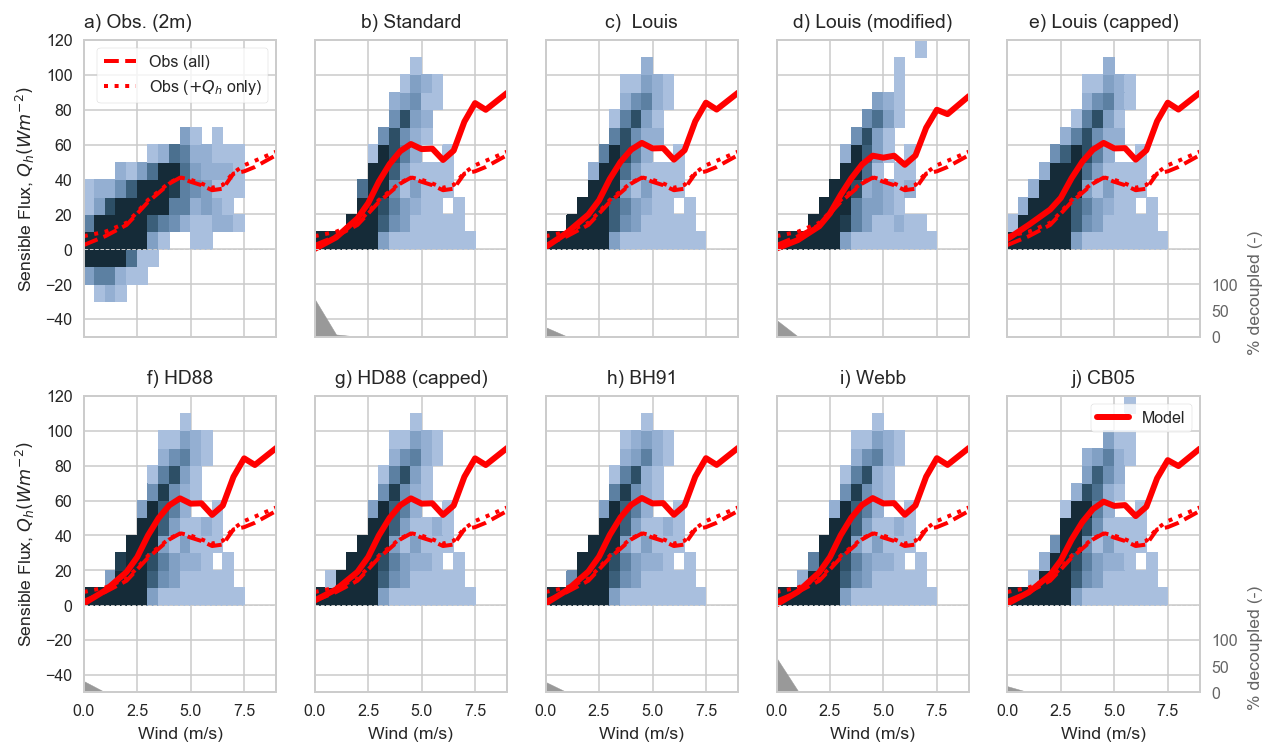

In [14]:
# -------------------------------------------------------------------------------------------------------
# SCP Lower Obs
os.chdir(dir_print)

# Temporary dataset with only the stable observations and stable and non-counter gradient
scp_temp = scp.isel_points(time=scp_ind_2m[0])
scp_ind_2m_noncg = np.nonzero(((scp.RiBulk_2m > 0.).values) & ((-scp.obs_qh_2m > 0)).values)
scp_temp_nocg = scp.isel_points(time=scp_ind_2m_noncg[0])
scp_2m['UBar_2m'] = scp.UBar_2m[scp_ind_2m]

# Temperature gradient bins
binWind = np.append(np.arange(0, 2, 1), np.arange(2, 8, 0.5))
binWind = np.append(binWind, np.arange(8, 11, 1))

# Bin obs
groupQhObs = proxyGroupby(scp_temp, 'UBar_2m', binWind, 'obs_qh_2m')
groupQhObs_nocg = proxyGroupby(scp_temp_nocg, 'UBar_2m', binWind, 'obs_qh_2m')

# Small flux threshold
small_qh_crit = 0.1

# Figure formatting
fig, axes = plt.subplots(2, 5, figsize=(10, 6))#, sharex=True, sharey=True)
axes = axes.flatten()
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)
cmap = kgraph.cmap_discretize(cmap, ncol)

ymin = -50
ymax = 120
xmin = 0
xmax = 9

## Observed turbulence
ax = axes[0]

# Build my own histogram
X = scp.UBar_2m[scp_ind_2m].values.flatten()
Y = -scp.obs_qh_2m[scp_ind_2m].values.flatten()  
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                               np.arange(ymin, ymax + dy, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)

# Plot my 2D histogram
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
ax.plot(binWind, -groupQhObs, '--r', linewidth=2, label='Obs (all)')
ax.plot(binWind, -groupQhObs_nocg, ':r', linewidth=2, label='Obs ($+Q_h$ only)')

ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
ax.set_title('a) Obs. (2m)', loc='left')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.grid()
ax.set_ylabel('Sensible Flux, $Q_h (Wm^{-2})$')
ax.set_xticklabels(())
ax.legend(frameon=True, loc='upper right')

## Count of very small fluxes (<= 0.5Wm-2)
ax2 = ax.twinx()
small_qh = xr.Dataset()
small_qh['obs_qh_2m'] = scp.obs_qh_2m[scp_ind_2m].where(np.abs(scp.obs_qh_2m[scp_ind_2m]) <= small_qh_crit, drop=True)
small_qh['UBar_2m'] = copy.deepcopy(scp['UBar_2m'].reindex_like(small_qh))
group_small_qh = proxyGroupby(small_qh, 'UBar_2m', binWind, 'obs_qh_2m', method='count')
group_all_qh = proxyGroupby(scp_temp, 'UBar_2m', binWind, 'obs_qh_2m', method='count')

ax2.fill_between(binWind, 0, group_small_qh / group_all_qh * 100, color='0.6')
print(group_small_qh / group_all_qh * 100)

if ax.is_last_col():
    ax2.set_ylabel('% decoupled (-)', color='0.6')
    ax2.tick_params('y', colors='0.6')
else:
    ax2.set_yticklabels(())
ax2.set_ylim(0, (ymax - ymin) / 30 * 100)
ax2.grid(False)

# Simulated turbulence
for ix, stab in enumerate(stab_titles):
    ax = axes[ix + 1]
    method = out_titles[stab]

    ## 2D Histogram
    # Bin the model output
    groupQh = proxyGroupby(scp_2m, 'UBar_2m', binWind, method)
    
    # Build my own histogram
    X = scp.UBar_2m[scp_ind_2m].values.flatten()
    Y = scp_2m[method].values.flatten()  
    H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                                   np.arange(ymin, ymax + dy, dy)))
    H = np.ma.masked_array(H, H < cmin + dcol)
    # Plot my 2D histogram
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
    ax.plot(binWind, groupQh, 'r', linewidth=3, label='Model')
    ax.plot(binWind, -groupQhObs, '--r', linewidth=2,)
    ax.plot(binWind, -groupQhObs_nocg, ':r', linewidth=2)

    ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
    ax.set_title(alphabet[ix + 1] + ') ' + axis_titles[stab])
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    
    if ax.is_last_row():
        ax.set_xlabel('Wind (m/s)')
    else:
        ax.set_xticklabels(())
    if ax.is_first_col():
        ax.set_ylabel('Sensible Flux, $Q_h (Wm^{-2})$')
    else:
        ax.set_yticklabels(())
    ax.grid()
    
    ## Count of very small fluxes (<= 0.5Wm-2)
    ax2 = ax.twinx()
    small_qh = xr.Dataset()
    small_qh[method] = scp_2m[method].where(scp_2m[method] <= small_qh_crit, drop=True)
    small_qh['UBar_2m'] = copy.deepcopy(scp['UBar_2m'].reindex_like(small_qh))
    group_small_qh = proxyGroupby(small_qh, 'UBar_2m', binWind, method, method='count')
    group_all_qh = proxyGroupby(scp_2m, 'UBar_2m', binWind, method, method='count')

    ax2.fill_between(binWind, 0, group_small_qh / group_all_qh * 100, color='0.6')
    
    ax2.set_yticks((0, 50, 100))
    if ax.is_last_col():
        ax2.set_ylabel('% decoupled (-)', color='0.4')
        ax2.tick_params('y', colors='0.4')
        ax2.set_yticklabels((0, 50, 100))
        ax2.yaxis.set_label_coords(1.25, 0.15)

    else:
        ax2.set_yticklabels(())
    ax2.set_ylim(0, (ymax - ymin) / 30 * 100)
    ax2.grid(False)

ax.legend(frameon=True)

fig.savefig('2dHist_Shear.SCP_2m.' + context + '.' + z0assumption + '.pdf', dpi=300)

The points appearing for higher wind speeds in the MO schemes that do not appear in the bulk schemes are because I'm masking bins with less than 10 observations within them. The MO schemes concentrate all of their points within the Q_h bins less than 20Wm-2, whereas the bulk methods allow for a range of turbulence at these higher wind values, leading to no bins having more than 20 points within them.

/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:973: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


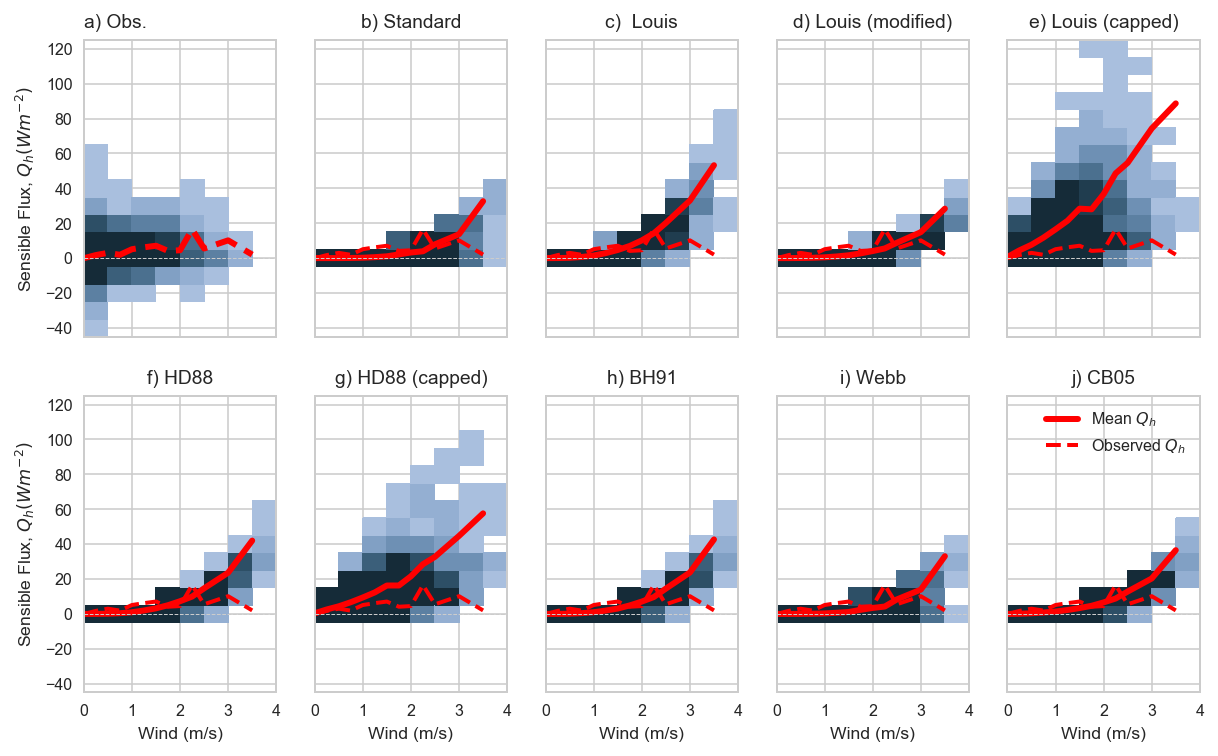

In [15]:
# -------------------------------------------------------------------------------------------------------
# SNQ
os.chdir(dir_print)

# Temporary dataset with only the stable observations
snq_temp = snq.isel(time=snq_ind[0])
snq_qh['WIND'] = snq.WIND[snq_ind]

# Wind speed bins
binWind = np.append(np.arange(0, 2.5, 0.25), np.arange(2.5, 4., 0.5))

# Bin obs
groupQhObs = proxyGroupby(snq_temp, 'WIND', binWind, 'SensFlux')

ymin = -45
ymax = 125
xmin = 0
xmax = 4.

# Figure formatting
fig, axes = plt.subplots(2, 5, figsize=(10, 6))#, sharex=True, sharey=True)
axes = axes.flatten()
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)
cmap = kgraph.cmap_discretize(cmap, ncol)

# Observed turbulence
ax = axes[0]

# Build my own histogram
X = snq.WIND[snq_ind].values.flatten()
Y = snq.SensFlux[snq_ind].values.flatten()  
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                               np.arange(ymin, ymax + dy, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)

# Plot my 2D histogram
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
ax.plot(binWind, groupQhObs, '--r', linewidth=3, label='Mean $Q_h$')

ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
ax.set_title('a) Obs.', loc='left')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.grid()
ax.set_ylabel('Sensible Flux, $Q_h (Wm^{-2})$')
ax.set_xticklabels(())

# Simulated turbulence
for ix, stab in enumerate(stab_titles):
    ax = axes[ix + 1]
    method = out_titles[stab]

    # Bin the model output
    groupQh = proxyGroupby(snq_qh, 'WIND', binWind, method)
    
    # Build my own histogram
    X = snq.WIND[snq_ind].values.flatten()
    Y = snq_qh[method].values.flatten()  
    H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                                   np.arange(ymin, ymax + dy, dy)))
    H = np.ma.masked_array(H, H < cmin + dcol)
    # Plot my 2D histogram
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
    ax.plot(binWind, groupQh, 'r', linewidth=3, label='Mean $Q_h$')
    ax.plot(binWind, groupQhObs, '--r', linewidth=2, label='Observed $Q_h$')

    ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
    ax.set_title(alphabet[ix + 1] + ') ' + axis_titles[stab])
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    
    if ax.is_last_row():
        ax.set_xlabel('Wind (m/s)')
    else:
        ax.set_xticklabels(())
    if ax.is_first_col():
        ax.set_ylabel('Sensible Flux, $Q_h (Wm^{-2})$')
    else:
        ax.set_yticklabels(())
    ax.grid()

ax.legend()

# The missing subaxis needs to be dealt with.
# ax = axes[-1]
# ax.set_xlabel(r'$\theta_{air} - \theta_{sfc} (^{\circ} C)$')
# ax.set_xticks((0, 2.5, 5, 7.5))
# ax.set_xticklabels(('0.0', '2.5', '5.0', '7.5'))

    
# Space for adding the colorbar
# ax = axes[-1]
# ax.axis('off')

fig.savefig('2dHist_Shear.SNQ.' + context + '.' + z0assumption + '.pdf')

# $z_0$ controls the slope of $Q_h(U)$ in regime 2

It does not control the location of the transition between turbulence regimes. Let us do a simple test of determining if this is important to our results.

In [33]:
## Met variables, varying wind speed
sfcTemp = 273
airTemp = 276
windspd = np.arange(0., 10, 0.25)
mHeight = 10.
snowDepth = 0.
scalarGroundSnowFraction  = 1.
(airVaporPress, _) = turbpy.satVapPress(airTemp - 273.)
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp - 273.)
airPressure = 101000.

RiBulk = turbpy.bulkRichardson(airTemp, sfcTemp, windspd, mHeight)

## Model dictionary
stab_titles = ['Standard',
               'Louis (b = 4.7)',
               'Louis (b = 12)',
               'Louis (Ri capped, MJ98)',
               'MO (Holtslag/de Bruin)',
               'MO (Holtslag/de Bruin - capped)',
               'MO (Beljaars/Holtslag)',
               'MO (Webb - NoahMP)',
               'MO (Cheng/Brutsaert)',
              ]

stab_methods = {'Standard': 'standard',
                'Louis (b = 4.7)': 'louis',
                'Louis (b = 12)': 'louis',
                'Louis (Ri capped, MJ98)': 'louis',
                'MO (Holtslag/de Bruin)': 'monin_obukhov',
                'MO (Holtslag/de Bruin - capped)': 'monin_obukhov',
                'MO (Beljaars/Holtslag)': 'monin_obukhov',
                'MO (Webb - NoahMP)': 'monin_obukhov',
                'MO (Cheng/Brutsaert)': 'monin_obukhov',
               }

gradient_funcs = {'MO (Holtslag/de Bruin)': 'holtslag_debruin',
                  'MO (Holtslag/de Bruin - capped)': 'holtslag_debruin',
                  'MO (Beljaars/Holtslag)': 'beljaar_holtslag',
                  'MO (Beljaars/Holtslag - capped)': 'beljaar_holtslag',
                  'MO (Cheng/Brutsaert)': 'cheng_brutsaert',
                  'MO (Webb - NoahMP)': 'webb_noahmp',
                 }

params = {'Louis (b = 4.7)': 9.4,
          'Louis (Ri capped, MJ98)': 9.4,
          'Louis (b = 12)': 24.}

capping = {'Louis (Ri capped, MJ98)': 'louis_Ri_capping',
           'MO (Holtslag/de Bruin - capped)': 'windless_exchange',
          }

## Simulate turbulence

# Initialize the multi-level parameter dictionary
stab_dict = {}
stab_dict['stability_params'] = {}

for st in stab_methods:
    stab_dict[st] = {}
    
    # Assigning the stability method
    stab_dict[st]['stability_method'] = stab_methods[st]
    
    # Assigning the gradient method
    if 'monin_obukhov' in stab_methods[st]:
        stab_dict[st]['monin_obukhov'] = {}
        stab_dict[st]['monin_obukhov']['gradient_function'] = gradient_funcs[st]
        stab_dict[st]['monin_obukhov']['roughness_function'] = 'constant_z0'
        
    # Assiging the capping behavior
    if st in capping.keys():
        stab_dict[st]['capping'] = capping[st]
    
    # Determine stability params
    if st in params.keys():
        stab_dict[st]['stability_params'] = {stab_methods[st]: params[st]}    


## Calculate stability

# Initialzie dictionaries for containing output
stability_correction = {}
conductance_sensible = {}
sensible_heat = {}
zeta = {}
z0_arr = {}

for stab in stab_titles:
    stability_correction[stab] = np.zeros((RiBulk.size, 3))
    conductance_sensible[stab] = np.zeros((RiBulk.size, 3))
    sensible_heat[stab] = np.zeros((RiBulk.size, 3))
    zeta[stab] = np.zeros((RiBulk.size, 3))
    z0_arr[stab] = np.zeros((RiBulk.size, 3))

## Calculate stability
for stab in stab_titles:
    for nz, z0 in enumerate((0.05, 0.005, 0.0005)):
        for n, u in enumerate(windspd):


            # Offline Turbulence Package
            (conductance_sensible[stab][n, nz], _,
             sensible_heat[stab][n, nz], _,
             stab_output, p_test) = turbpy.turbFluxes(airTemp, airPressure,
                                                      airVaporPress, u, sfcTemp,
                                                      sfcVaporPress, snowDepth,
                                                      mHeight, param_dict=stab_dict[stab],
                                                      z0Ground=z0)

            # Unpack stability parameters dictionary
            if 'monin_obukhov' in stab_methods[stab]:
                z0_arr[stab][n, nz] = stab_output['z0']


- 0.005
-. 0.0005
- 0.005
-. 0.0005
- 0.005
-. 0.0005


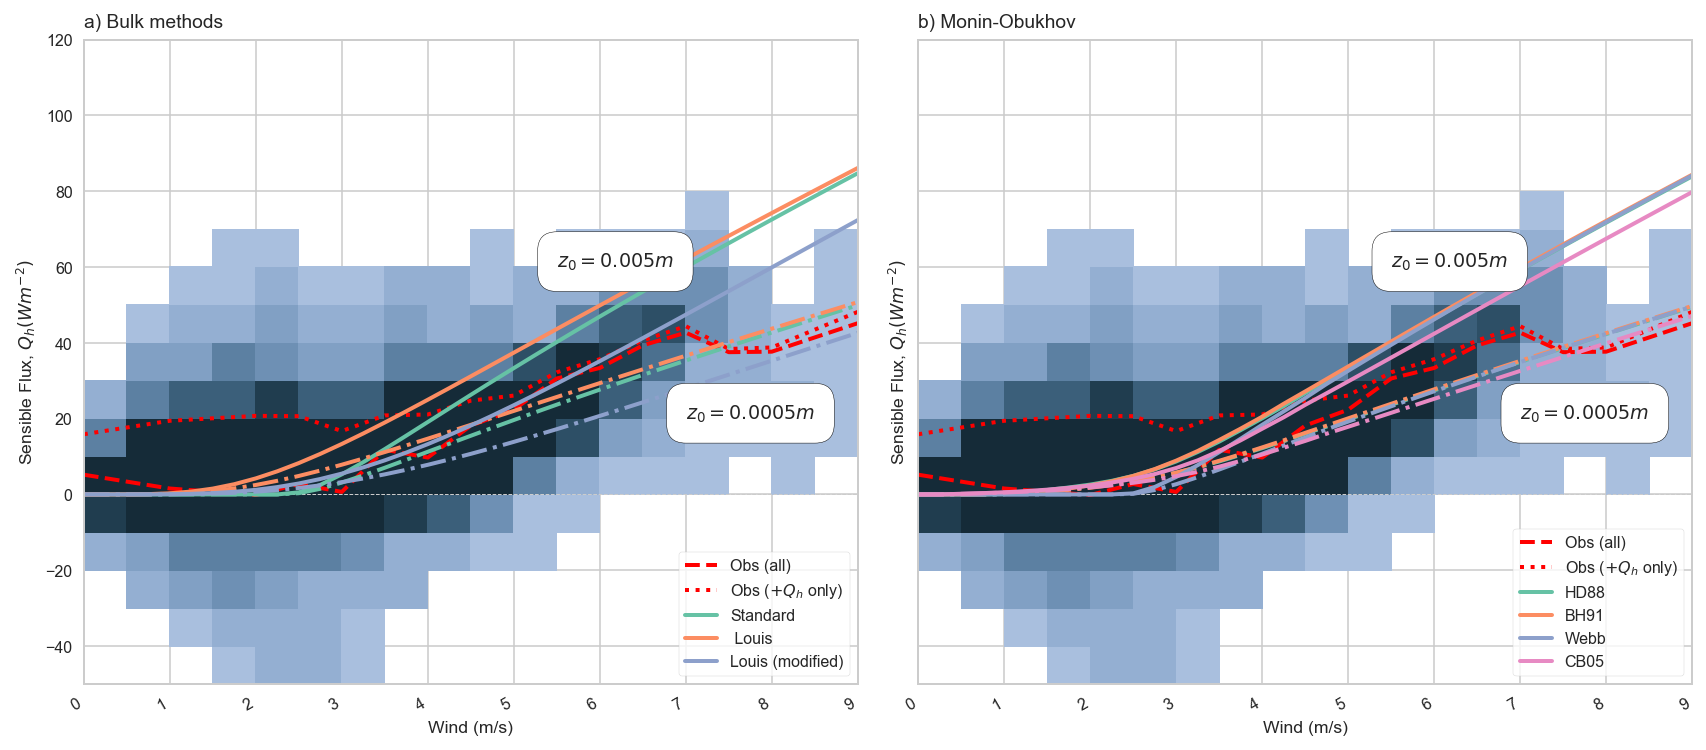

In [55]:
# Colorblind friendly colors
c = sns.color_palette("Set2")

# Figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.flatten()

# Temporary dataset with only the stable observations
scp_temp = scp.isel_points(time=scp_ind_10m[0])
scp_ind_10m_noncg = np.nonzero(((scp.RiBulk_10m > 0.).values) & ((-scp.obs_qh_10m > 0)).values)
scp_temp_nocg = scp.isel_points(time=scp_ind_10m_noncg[0])
scp_10m['UBar_10m'] = scp.UBar_10m[scp_ind_10m]

# Temperature gradient bins
binWind = np.append(np.arange(0, 2, 1), np.arange(2, 8, 0.5))
binWind = np.append(binWind, np.arange(8, 11, 1))

# Bin obs
groupQhObs = proxyGroupby(scp_temp, 'UBar_10m', binWind, 'obs_qh_10m')
groupQhObs_nocg = proxyGroupby(scp_temp_nocg, 'UBar_10m', binWind, 'obs_qh_10m')

# Figure formatting
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)
cmap = kgraph.cmap_discretize(cmap, ncol)

# Plotting parameters
ymin = -50
ymax = 120
xmin = 0
xmax = 9

## Observed turbulence
ax = axes[0]

# Build my own histogram
X = scp.UBar_10m[scp_ind_10m].values.flatten()
Y = -scp.obs_qh_10m[scp_ind_10m].values.flatten()  
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                               np.arange(ymin, ymax + dy, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)

# Plot my 2D histogram
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
ax.plot(binWind, -groupQhObs, '--r', linewidth=2, label='Obs (all)')
ax.plot(binWind, -groupQhObs_nocg, ':r', linewidth=2, label='Obs ($+Q_h$ only)')

ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
ax.set_title('a) Obs. (10m)', loc='left')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.grid()
ax.set_ylabel('Sensible Flux, $Q_h (Wm^{-2})$')


ls = ['-', '-.', ':']
bulk_stabs = [s for s in stab_titles if not stab_methods[s] == 'monin_obukhov' and 'capped' not in s]
most_stabs = [s for s in stab_titles if stab_methods[s] == 'monin_obukhov' and 'capped' not in s] 

# Bulk methods
for nstab, stab in enumerate(bulk_stabs):
    for nz, z in enumerate((0.005, 0.0005)):
        print(ls[nz], z)
        # Sensible Heat Flux
        if z == 0.005:
            label = axis_titles[stab]
        else:
            label = ''
        ax.plot(windspd, sensible_heat[stab][:, nz + 1], label=label, ls=ls[nz], color=c[nstab], linewidth=2)

ax = axes[0]
ax.set_title('a) Bulk methods', loc='left')
ax.set_xlabel('Wind (m/s)')
lgd = ax.legend(loc='lower right', frameon=True)
# ax.text(5.1, 105, '$z_0 = 0.05m$', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
ax.text(5.5, 60, '$z_0 = 0.005m$', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
ax.text(7, 20, '$z_0 = 0.0005m$', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

## Observed turbulence
ax = axes[1]

# Build my own histogram
X = scp.UBar_10m[scp_ind_10m].values.flatten()
Y = -scp.obs_qh_10m[scp_ind_10m].values.flatten()  
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                               np.arange(ymin, ymax + dy, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)

# Plot my 2D histogram
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
ax.plot(binWind, -groupQhObs, '--r', linewidth=2, label='Obs (all)')
ax.plot(binWind, -groupQhObs_nocg, ':r', linewidth=2, label='Obs ($+Q_h$ only)')

ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
ax.set_title('a) Obs. (10m)', loc='left')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.grid()
ax.set_ylabel('Sensible Flux, $Q_h (Wm^{-2})$')

# Monin Obukhov methods
for nstab, stab in enumerate(most_stabs):
    for nz, z in enumerate((0.005, 0.0005)):
        # Sensible Heat Flux
        # Sensible Heat Flux
        if z == 0.005:
            label = axis_titles[stab]
        else:
            label = ''
        ax.plot(windspd, sensible_heat[stab][:, nz + 1], label=label, ls=ls[nz], color=c[nstab], linewidth=2)

ax.set_xlabel('Wind (m/s)')
ax.set_title('b) Monin-Obukhov', loc='left')
lgd = ax.legend(loc='lower right', frameon=True)
# ax.text(5.1, 105, '$z_0 = 0.05m$', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
ax.text(5.5, 60, '$z_0 = 0.005m$', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
ax.text(7, 20, '$z_0 = 0.0005m$', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

fig.tight_layout()
fig.autofmt_xdate()
os.chdir(dir_print)
fig.savefig('TF.idealized.z0.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('TF.idealized.z0.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')

Magnitude of z0 effects the slope of Q_h(U) but not the location of the transition.

In [31]:
c

[(0.0, 0.4470588235294118, 0.6980392156862745),
 (0.0, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.4745098039215686, 0.6549019607843137),
 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]